# Week 3: Fitting

In many different cases, we might have a model for how a system works, and want to fit that model to a set of observations. 

We're going to investigate a paper using a classic model of multivalent binding to [examine interaction of IgG antibodies with the immune system](https://doi.org/10.1016/j.cels.2018.05.018). Identifying whether and how this model fits has led to a better understanding of how our immune system recognizes diseased cells, and how to design antibodies with optimized responses.

In [1]:
%matplotlib inline
from math import inf
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import binom
from scipy.optimize import brentq

np.seterr(over='raise')

def bindingModel(Rtot, Ka, v, L0):
    '''
    Returns the number of mutlivalent ligand bound to a cell with Rtot
    receptors, granted each epitope of the ligand binds to the receptor
    kind in question with association constant Ka and cross-links with
    other receptors with crosslinking constant Kx. All eq derived from
    Stone et al. (2001).

    Note that this function only takes a single condition at once. All
    arguments should be scalars (not vectors)!
    '''
    v = np.int_(v)
    Kx = np.power(10.0, -12.25)
    
    # Mass balance for receptor species, to identify the amount of free receptor
    diffFunAnon = lambda x: Rtot-x*(1+v*L0*(Ka)*(1+Kx*x)**(v-1))
    
    ## Solve Req by calling least_squares
    Req, lsq = brentq(diffFunAnon, 0.0, Rtot, full_output=True)
    if lsq.converged is False:
        print(lsq)
        raise RuntimeError("Failure in solving for Req.")
    
    # Calculate vieq from equation 1
    vieq = L0*Req*binom(v, np.arange(1, v + 1))*np.power(Kx*Req, np.arange(v))*Ka
    return np.sum(vieq)


# L0 for each TNP-BSA
# Define concentrations of TNP-4-BSA and TNP-26-BSA, respectively
tnpbsaL0 = np.array([1/67122,1/70928])*1e-3*5

#### (1) Load the data (`robinett.csv`, from Fig. 1). Decide how to account for the control conditions. Plot the data and explore the relationship you see with affinity and valency (see Fig. 1C/D/E for ideas).

[0.e+00 6.e+07 0.e+00 6.e+07 3.e+07 0.e+00 3.e+06 1.e+05 9.e+05 2.e+05
 0.e+00 5.e+06 4.e+05 9.e+05 2.e+05 0.e+00 1.e+05 2.e+04 2.e+05 2.e+05
 0.e+00 1.e+05 3.e+04 8.e+06 2.e+05 0.e+00 2.e+05 7.e+04 1.e+07 2.e+05]
[-2.2100e+00  6.0040e+01  4.1040e+01  6.7790e+01  5.1790e+01  2.9000e-01
  5.2290e+01  1.0790e+01  1.2279e+02  2.0040e+01 -2.4600e+00  2.7254e+02
  1.7104e+02  2.7879e+02  1.0554e+02 -2.9600e+00  2.7540e+01  7.2900e+00
  8.7790e+01  1.7790e+01  5.5400e+00  3.4904e+02  1.9790e+01  4.2504e+02
  1.3790e+01  1.7900e+00  3.3429e+02  6.6040e+01  4.1854e+02  1.9029e+02]


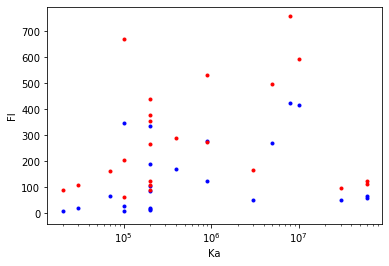

In [11]:
# Answer
data = np.genfromtxt("Robinett.csv", delimiter = ",")
lowv = data[1:,2] -9.96 # accounts for control conditions (subtracted because that is the amount of flouresence just at nominal)
highv = data[1:,3] -9.96 #(9.96 average flouresent light control condition to subrtract from each)
ka = data[1:,4]
print(ka)
print(lowv)

plt.semilogx(ka, lowv, 'b.') #amount of binding vs. affinity to the interaction (log axis on the x(ka) axis) low valency interaction
plt.semilogx(ka, highv, 'r.') #high valency
plt.xlabel('Ka')
plt.ylabel('FI'); #flourescence INdex
#can remove controls


#### (2) To fit the model, we'll first need a function that takes the unknown parameters (Rtot, scaling), uses them to run the model for each condition, scales them to the units of the actual measurements (fluorescence), thus finding the predictions for each condition.

Use the fit parameters shown in Fig. 2 and overlay with the measurements to ensure your function is roughly working. The scaling to fluorescence units for each valency should themselves be unknown parameters.

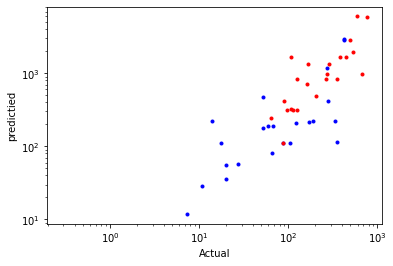

<Figure size 432x288 with 0 Axes>

In [12]:
# Answer (function that takes in rtotal and scaling factors and gives back prediction for how much flouresence 

    #values we think are good to start the fitting (rough values from the paper) 
Rtotnought = np.array([1e5, 5e5, 1e6, 1e6, 2e6,2e6]) #rtotal is here, so in binding model we index out to 
scalenought = np.power(10.0, [-5.7, -5.5]) *1000 #variable outside function can also be accessible inside, so if you put the same name in the variables of function, weird things can occur (give unique arguments)
    
    
def prediction(Rtotin, ScaleIn):
    predictions = np.zeros((lowv.size, 2))
        
    for ii in range(lowv.size):
        predictions[ii, 0] = bindingModel(Rtotin[ii // 5], ka[ii], 4, tnpbsaL0[0]) #Rtotin(divide and round down) the index for each receptor (index 0 -5) for each type of receptor
        #print(Rtotin[ii //5])
        #print(ka[ii])
        predictions[ii, 1] = bindingModel(Rtotin[ii // 5], ka[ii], 26, tnpbsaL0[1]) #creates a data structure of an array of the rows number as data file and columns for tnp4 and tnp 26
            
    predictions[:, 0] *= ScaleIn[0]
    predictions[:, 1] *= ScaleIn[1] #scale columns
        
    return predictions #v(valency)


    
    
outt = prediction(Rtotnought, scalenought)
#print(outt[:,0])        
plt.loglog(lowv, outt[:, 0], 'b.')
plt.loglog(highv, outt[:,1], 'r.')
plt.xlabel("Actual")
plt.ylabel("predictied")
plt.figure();
#plt.plot(lowv, outt[:, 0], 'b.')
#plt.plot(highv, outt[:,1], 'r.')     
#actual is just shifted by 1000 higher, because paper divides by sum of mean or something like that
#looks like there is agreement that groupings from predicted follow our model

#### (3) Now use `scipy.optimize.least_squares` to find the least squares solution.

In [17]:
# Answer
    #least squares needs one array input and then we need the return of the residuals
    #residuals is function for least squares 
from scipy.optimize import least_squares

Rtotnought = np.array([1e5, 5e5, 1e6, 1e6, 2e6,2e6]) #rtotal is here, so in binding model we index out to 
scalenought = np.power(10.0, [-5.7, -5.5]) *1000 #variable outside function can also be accessible inside, so if you put the same name in the variables of function, weird things can occur (give unique arguments)
    
    
def prediction(Rtotin, ScaleIn):
    predictions = np.zeros((lowv.size, 2))
        
    for ii in range(lowv.size):
        predictions[ii, 0] = bindingModel(Rtotin[ii // 5], ka[ii], 4, tnpbsaL0[0]) #Rtotin(divide and round down) the index for each receptor (index 0 -5) for each type of receptor
        #print(Rtotin[ii //5])
        #print(ka[ii])
        predictions[ii, 1] = bindingModel(Rtotin[ii // 5], ka[ii], 26, tnpbsaL0[1]) #creates a data structure of an array of the rows number as data file and columns for tnp4 and tnp 26
            
    predictions[:, 0] *= ScaleIn[0]
    predictions[:, 1] *= ScaleIn[1] #scale columns
        
    return predictions #v(valency)
    
def residuals(x):
    predd = prediction(x[:6], x[6:]) # x[:6] index x up to 6, not including 6, x[6:] index including 6 and beyond
    #print(predd)
    predd[:, 0] = (predd[:, 0]) - (lowv)
    predd[:, 1] = (predd[:, 1]) - (highv)
    #print(predd.flatten())
    
    return (predd.flatten())

initials = np.concatenate((Rtotnought, scalenought))
#print(initials)
res = residuals(np.concatenate((Rtotnought, scalenought)))

#print(res)
#returns the differences between the predicted values, 

#least squares is giong to try to minimize the mse of the residuals to get the optimal value

ls = least_squares(residuals, initials, bounds=(0.0, np.inf)) #args=(crime, distance, homeprice))# args = np.concatenate((lowv,highv)))
fitparams = ls.x
cost = ls.cost
print('The least square parameters solutions are:' ,fitparams)
print('The above parameters are the set of values that give the minimum SSE value given all the independent parameters')
print('Minimum Sum of SSE for independent parameters:' ,cost)

ls3 = least_squares(residuals, initials, bounds=(np.zeros_like(initials), np.full_like(initials, np.inf)), jac="3-point") #args=(crime, distance, homeprice))# args = np.concatenate((lowv,highv)))
fitparams3 = ls3.x
res = ls3.fun
cost3 = ls3.cost

print(fitparams3)

The least square parameters solutions are: [8.23061595e+04 2.26159737e+05 5.58854462e+05 6.69712569e+05
 6.83217605e+05 6.11716099e+05 9.66394482e-04 1.24880328e-03]
The above parameters are the set of values that give the minimum SSE value given all the independent parameters
Minimum Sum of SSE for independent parameters: 405362.45841135853
[8.23061660e+04 2.26159747e+05 5.58854509e+05 6.69712628e+05
 6.83217657e+05 6.11716155e+05 9.66394402e-04 1.24880318e-03]


#### (4) Using leave-one-out crossvalidation, does this model predict the data? Plot the measured vs. predicted data.

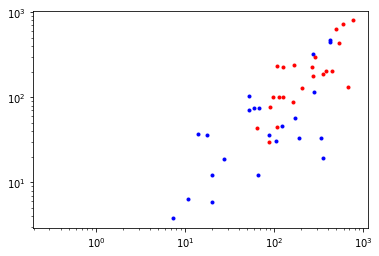

In [6]:
# Answer
best_vals = fitparams
pred_value = prediction(best_vals[:6],best_vals[6:])
plt.loglog(lowv, pred_value[:, 0], 'b.')
plt.loglog(highv, pred_value[:,1], 'r.')


from sklearn.model_selection import LeaveOneOut
leave = LeaveOneOut()
estimates = []

allv = np.concatenate((lowv,highv))

Rtotnought = np.array([1e5, 5e5, 1e6, 1e6, 2e6,2e6]) #rtotal is here, so in binding model we index out to 
scalenought = np.power(10.0, [-5.7, -5.5]) #variable outside function can also be accessible inside, so if you put the same name in the variables of function, weird things can occur (give unique arguments)
    
    
def predictiont(Rtotin, ScaleIn):
    predictionst = np.zeros((lowv.size-1, 2))
    for train_index in range(lowv.size-1):
        predictionst[train_index, 0] = bindingModel(Rtotin[train_index // 5], ka[train_index], 4, tnpbsaL0[0]) 
        predictionst[train_index, 1] = bindingModel(Rtotin[train_index // 5], ka[train_index], 26, tnpbsaL0[1])          
    predictionst[:, 0] *= ScaleIn[0]
    predictionst[:, 1] *= ScaleIn[1] 
    
    return predictionst
    #   predictions[ii, 0] = bindingModel(Rtotin[ii // 5], ka[ii], 4, tnpbsaL0[0]) #Rtotin(divid and round down) the index for each receptor (index 0 -5) for each type of receptor
        #print(Rtotin[ii //5])
        #print(ka[ii])
    #    predictions[ii, 1] = bindingModel(Rtotin[ii // 5], ka[ii], 26, tnpbsaL0[1]) #creates a data structure of an array of the rows number as data file and columns for tnp4 and tnp 26
            
   # predictions[:, 0] *= ScaleIn[0]
   # predictions[:, 1] *= ScaleIn[1] #scale columns
        
    #return predictions 
#predictionst = np.zeros((lowv.size, 2))
#def predictiont(Rtotint,ScaleInt)
    #for ii in range(lowv.size):
def residualst(x, tid):
    preddt = predictiont(x[:6], x[6:]) # x[:6] index x up to 6, not including 6, x[6:] index including 6 and beyond
    #print(predd)
    preddt[:, 0] = (preddt[:, 0]) - (lowv[tid])
    preddt[:, 1] = (preddt[:, 1]) - (highv[tid])
    
    return (preddt.flatten())        
    
    
    

Rtotin = fitparams[:6]
ScaleIn = fitparams[6:]
for train_index, test_index in leave.split(lowv):
    predictiont(Rtotin, ScaleIn)
    trained_lowv = lowv[train_index]
    trained_highv = highv[train_index]
    ls = least_squares(residualst, fitparams, args = test_index ) #args=(crime, distance, homeprice))# args = np.concatenate((lowv,highv)))
    fitp = ls.x
    #print(train_index)
    estimates = np.append(estimates, predictiont(fitp[:6],fitp[:6]))
    
#print(np.size(estimates));


In [7]:
#print(estimates[0:100])

#### (7) Now, we will perform a local sensitivity analysis to look at the dependence of the model results on each parameter. Vary each parameter up and down by 10-fold **while holding the others constant**, and plot the sum of squared error. Which parameter influences the fit the most? Which one the least?

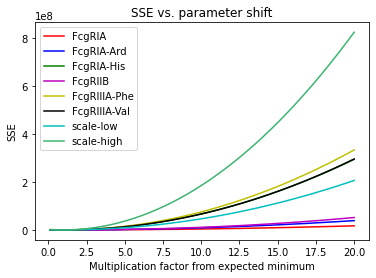

In [18]:
# Answer
initials = np.concatenate((Rtotnought, scalenought))
#print(initials)
res = residuals(np.concatenate((Rtotnought, scalenought)))


Rtotnought = np.array([1e5, 5e5, 1e6, 1e6, 2e6,2e6]) #rtotal is here, so in binding model we index out to 
scalenought = np.power(10.0, [-5.7, -5.5]) #variable outside function can also be accessible inside, so if you put the same name in the variables of function, weird things can occur (give unique arguments)
    
    
def prediction(Rtotin, ScaleIn):
    predictions = np.zeros((lowv.size, 2))
        
    for ii in range(lowv.size):
        predictions[ii, 0] = bindingModel(Rtotin[ii // 5], ka[ii], 4, tnpbsaL0[0]) #Rtotin(divid and round down) the index for each receptor (index 0 -5) for each type of receptor
        #print(Rtotin[ii //5])
        #print(ka[ii])
        predictions[ii, 1] = bindingModel(Rtotin[ii // 5], ka[ii], 26, tnpbsaL0[1]) #creates a data structure of an array of the rows number as data file and columns for tnp4 and tnp 26
            
    predictions[:, 0] *= ScaleIn[0]
    predictions[:, 1] *= ScaleIn[1] #scale columns
        
    return predictions #v(valency)




#def ssegraph(x):
ssearray = np.zeros([8,200])
ressquared = np.zeros(8)
ls = least_squares(residuals, initials) #args=(crime, distance, homeprice))# args = np.concatenate((lowv,highv)))
x = ls.x
fitparams = x
for i in range (0, np.size(x)): 
    #print(fitparams[0])
    x = [2.38646981e+08, 6.56379552e+08, 1.62442295e+09, 1.93313090e+09,
         1.98601072e+09, 1.77968728e+09, 3.32434820e-07, 4.29897163e-07]
    z = np.arange(0.1,20.1,0.1)
    for y in range (0, 200):
        x[i] = x[i]*z[y]          
        predd = prediction(x[:6], x[6:]) # x[:6] index x up to 6, not including 6, x[6:] index including 6 and beyond
        #print(predd)
        predd[:, 0] = (predd[:, 0]) - (lowv)
        predd[:, 1] = (predd[:, 1]) - (highv)
        res = predd.flatten()
        ressquared = np.square(res)
        ressumsquare = np.sum(ressquared)
        ssearray[i,y] = ressumsquare
        x = [2.38646981e+08, 6.56379552e+08, 1.62442295e+09, 1.93313090e+09,
         1.98601072e+09, 1.77968728e+09, 3.32434820e-07, 4.29897163e-07]

plt.plot(z,ssearray[0,:], color = 'red')
plt.plot(z,ssearray[1,:], color = 'b')
plt.plot(z,ssearray[2,:], color = 'g')
plt.plot(z,ssearray[3,:], color = 'm')
plt.plot(z,ssearray[4,:], color = 'y')
plt.plot(z,ssearray[5,:], color = 'k')    
plt.plot(z,ssearray[6,:], color = 'c')
plt.plot(z,ssearray[7,:], color = 'mediumseagreen') 
plt.xlabel("Multiplication factor from expected minimum")
plt.ylabel("SSE");
plt.title("SSE vs. parameter shift")
plt.gca().legend(['FcgRIA' , 'FcgRIA-Ard', 'FcgRIA-His', 'FcgRIIB', 'FcgRIIIA-Phe', 'FcgRIIIA-Val', 'scale-low', 'scale-high']) 

In [17]:
print(np.size(np.arange(0.1,20.1,0.1)))

200


The above plot shows how the Sum of Squared Error changes for the model when varying one parameter from the optimal solution given in least squares.
From the plot we can discern that the parameter with the most insluence on the SSE, and therefore influences the fit most is the scale-high parameter, followed by the FcgRIIIA-Phe receptor, FcgRIIIA-Val, and FCgRIA-His values. The least influential is the FcgRIA value, followed by the FcgRIA-Ard, and FcgRIIB. 

#### (8) While easier to perform, a local sensitivity analysis ignores codependency between the parameters. Do you anticipate your predictions of the parameter values will be more or less specified with a global analysis?

Answer.
I believe the predictions of the parameter values will be more specific, if we take into account the codedependecy of the paramater values (global analysis), than just with a local analysis, where all parameters are thought to be linearly independent. I think this because of the way that our model is created. It indivudually takes into account the fluorescence of the group of receptors, but the scales effect each group. This makes it so that the scales are very important locally, however, if the scales are allowed to shift optimally for each cases of the data, there may be more optimal single cases due to the interactions of the parameters. This will make the answer more specific. 

#### (9) Now, vary each parameter from the optimal solution, *allowing the other parameters to vary*. Was your prediction true? How are the other parameters varying when the scaling factor increases?

Hint: The easiest way to do this is mess with the bounds of the least squares solver.

In the below code you will see that my prediction is true. We found a lowest SSE and cost, overall, lower than the previous. Showing dependence of some variables on others, and changing which values we find to be the most influential on the model. 
When either scaling factor is lowered from the previous optimal, the other parameters all increase, and as the scaling factor approaches the original optimal value and then increaes, the other parameters decrease approximately exponentially. The minimum sse is found when the high scaling factor is lowered the most and the other parameters are increased more. Meaning that the high scaling does have the most impact on the SSE, and when it is lowered the most, the other parameters are able to increase more and this correlation is what is shown when we allow the other paramters to vary when calculating the optimal solution. 

In the first graph below, we see that only when forcing the 'FchRIIIA-Phe', 'FcgRIIIA-Val' parameters to be lower than optimal that the other values can not bring it down. Meaning the model may be more dependent on these values, (this is seen in how the model breaks in these times).  However, in all the rest we can see that no matter what the value is of the test parameter we are changing, that the other parameters have an influence on it. Meaning there is a strong suggestion of independence of these varialbles on the model (not as much influence). 

The graphs of the scaling favctors vs the other parameters shows a correlation between the flourescence of a receptor and the scaling factor. As the scaling factor decreases, the rtot increases. This makes sense because if we scaled the measurements to 0 than any light would represent a large amount of measurement being captures. This means the other variables may be dependent on the scaling factors, which fits with my prediction. 

So we can see that though globally the model is highly dependent on the scaling factors, it is actually most meaningfully dependent on 'FchRIIIA-Phe', 'FcgRIIIA-Val', because these are highly influential to the SSE, but yet are dependent on the scaling factors, and shown in the local analysis likely to affect our model the most. We can see this in the global analysis vs. the local analysis. As long as the scaling factor is set to the correct value, optimized, and understoood, then we can understand the results of the test be able to make predictions with the model. 


minimum sse value found by varying all 8 parameters from 0.1 to 10 times their original values and allowing all other values to find the lowest SSE from that is:  787524.473571379
This value is found at:  (array([7], dtype=int64), array([0], dtype=int64))
minimum cost value found by varying all 8 parameters from 0.1 to 10 times their original values and allowing all other values to find the lowest SSE from that is: 393762.2367856895
Found in array[], spot[] (array([7], dtype=int64), array([0], dtype=int64))
The minimum parameters are  [2.40712218e+09] [6.5819902e+09] [1.62908211e+10] [1.93114697e+10] [2.00963968e+10] [1.79364269e+10] [3.30389273e-08] [4.3253238e-08]


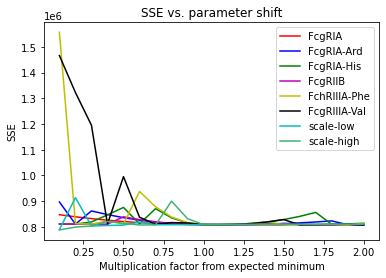

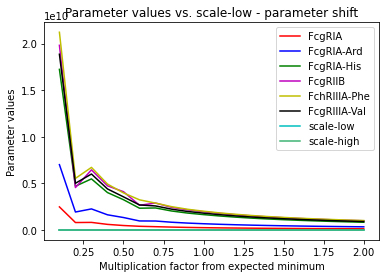

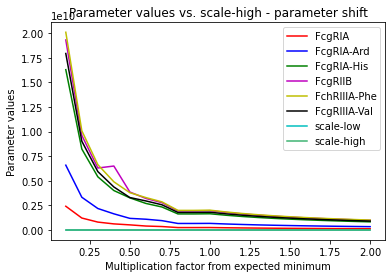

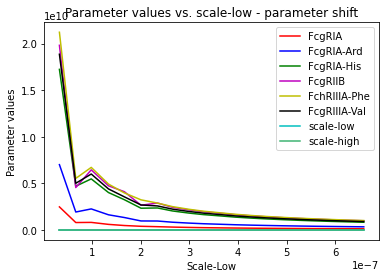

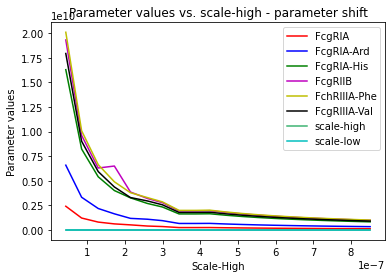

In [92]:
ssearray = np.zeros([8,20])
params = np.zeros([8,20])
ressquared = np.zeros(8)
a_params = []
zero_param = np.zeros([8, 20])
one_param = np.zeros([8, 20])
two_param = np.zeros([8, 20])
three_param = np.zeros([8, 20])
four_param = np.zeros([8, 20])
five_param = np.zeros([8, 20])
six_param = np.zeros([8, 20])
seven_param = np.zeros([8, 20])
cost = np.zeros([8,20])
ls = least_squares(residuals, initials) #args=(crime, distance, homeprice))# args = np.concatenate((lowv,highv)))
x = ls.x
fitparams = x
for i in range (0, np.size(x)): 
    #print(fitparams[0])
    x = [2.38646981e+08, 6.56379552e+08, 1.62442295e+09, 1.93313090e+09,
         1.98601072e+09, 1.77968728e+09, 3.32434820e-07, 4.29897163e-07]

    lbound = np.zeros_like(x)
    ubound = np.full_like(x, np.inf)
    z = np.arange(0.1,2.1,0.1)
    for y in range (0, 20):
        x[i] = x[i]*z[y]

        lbound[i] = x[i]
        ubound[i] = x[i]
        lbound[i] *= 0.99
        ubound[i] *= 1.01

        lsconstr = least_squares(residuals, x, bounds=(lbound, ubound), jac="3-point")
        #print(lsconstr.x)
        zero_param[i,y] = lsconstr.x[0]
        one_param[i,y] = lsconstr.x[1]
        two_param[i,y] = lsconstr.x[2]
        three_param[i,y] = lsconstr.x[3]
        four_param[i,y] = lsconstr.x[4]
        five_param[i,y] = lsconstr.x[5]
        six_param[i,y] = lsconstr.x[6]
        seven_param[i,y] = lsconstr.x[7]
        cost[i,y] = (lsconstr.cost)
        
        predd = prediction(lsconstr.x[:6], lsconstr.x[6:]) # x[:6] index x up to 6, not including 6, x[6:] index including 6 and beyond
        #print(predd)
        predd[:, 0] = (predd[:, 0]) - (lowv)
        predd[:, 1] = (predd[:, 1]) - (highv)
        res = predd.flatten()
        ressquared = np.square(res)
        ressumsquare = np.sum(ressquared)
        ssearray[i,y] = ressumsquare
        x = [2.38646981e+08, 6.56379552e+08, 1.62442295e+09, 1.93313090e+09,
         1.98601072e+09, 1.77968728e+09, 3.32434820e-07, 4.29897163e-07]       
    a_params.append(params) 
    
    
print('minimum sse value found by varying all 8 parameters from 0.1 to 10 times their original values and allowing all other values to find the lowest SSE from that is: ', 
      np.min(ssearray[:,:]))
print('This value is found at: ' , np.where(ssearray == np.min(ssearray[:,:])))
min_spot = np.where(ssearray == np.min(ssearray[:,:]))
min_c_spot = np.where(cost == np.min(cost[:,:]))
min_cost = np.min(cost)
print('minimum cost value found by varying all 8 parameters from 0.1 to 10 times their original values and allowing all other values to find the lowest SSE from that is:', min_cost)
print('Found in array[], spot[]', min_c_spot )

print('The minimum parameters are ', zero_param[min_spot[0] ,min_spot[1]], one_param[min_spot[0] ,min_spot[1]], two_param[min_spot[0] ,min_spot[1]], three_param[min_spot[0] ,min_spot[1]]
     ,four_param[min_spot[0] ,min_spot[1]], five_param[min_spot[0] ,min_spot[1]], six_param[min_spot[0] ,min_spot[1]], seven_param[min_spot[0] ,min_spot[1]])

plt.plot(z,ssearray[0,:], color = 'red')
plt.plot(z,ssearray[1,:], color = 'b')
plt.plot(z,ssearray[2,:], color = 'g')
plt.plot(z,ssearray[3,:], color = 'm')
plt.plot(z,ssearray[4,:], color = 'y')
plt.plot(z,ssearray[5,:], color = 'k')
plt.plot(z,ssearray[6,:], color = 'c')
plt.plot(z,ssearray[7,:], color = 'mediumseagreen') 
plt.xlabel("Multiplication factor from expected minimum")
plt.ylabel("SSE");
plt.title("SSE vs. parameter shift")
plt.gca().legend(['FcgRIA' , 'FcgRIA-Ard', 'FcgRIA-His', 'FcgRIIB', 'FchRIIIA-Phe', 'FcgRIIIA-Val', 'scale-low', 'scale-high']) 

plt.figure()
plt.plot(z,zero_param[6], color = 'r')
plt.plot(z,one_param[6], color = 'b')
plt.plot(z,two_param[6], color = 'g')
plt.plot(z,three_param[6], color = 'm')
plt.plot(z,four_param[6], color = 'y')
plt.plot(z,five_param[6], color = 'k')
plt.plot(z,six_param[6], color = 'c')
plt.plot(z,seven_param[6], color = 'mediumseagreen') 
plt.xlabel("Multiplication factor from expected minimum")
plt.ylabel("Parameter values");
plt.title("Parameter values vs. scale-low - parameter shift")
plt.gca().legend(['FcgRIA' , 'FcgRIA-Ard', 'FcgRIA-His', 'FcgRIIB', 'FchRIIIA-Phe', 'FcgRIIIA-Val', 'scale-low', 'scale-high']) 

plt.figure()
plt.plot(z,zero_param[7], color = 'r')
plt.plot(z,one_param[7], color = 'b')
plt.plot(z,two_param[7], color = 'g')
plt.plot(z,three_param[7], color = 'm')
plt.plot(z,four_param[7], color = 'y')
plt.plot(z,five_param[7], color = 'k')
plt.plot(z,six_param[7], color = 'c')
plt.plot(z,seven_param[7], color = 'mediumseagreen') 
plt.xlabel("Multiplication factor from expected minimum")
plt.ylabel("Parameter values");
plt.title("Parameter values vs. scale-high - parameter shift")
plt.gca().legend(['FcgRIA' , 'FcgRIA-Ard', 'FcgRIA-His', 'FcgRIIB', 'FchRIIIA-Phe', 'FcgRIIIA-Val', 'scale-low', 'scale-high']) 

plt.figure()
plt.plot(six_param[6],zero_param[6], color = 'r')
plt.plot(six_param[6],one_param[6], color = 'b')
plt.plot(six_param[6],two_param[6], color = 'g')
plt.plot(six_param[6],three_param[6], color = 'm')
plt.plot(six_param[6],four_param[6], color = 'y')
plt.plot(six_param[6],five_param[6], color = 'k')
plt.plot(six_param[6],six_param[6], color = 'c')
plt.plot(six_param[6],seven_param[6], color = 'mediumseagreen') 
plt.xlabel("Scale-Low")
plt.ylabel("Parameter values");
plt.title("Parameter values vs. scale-low - parameter shift")
plt.gca().legend(['FcgRIA' , 'FcgRIA-Ard', 'FcgRIA-His', 'FcgRIIB', 'FchRIIIA-Phe', 'FcgRIIIA-Val', 'scale-low', 'scale-high']) 

plt.figure()
plt.plot(seven_param[7],zero_param[7], color = 'r')
plt.plot(seven_param[7],one_param[7], color = 'b')
plt.plot(seven_param[7],two_param[7], color = 'g')
plt.plot(seven_param[7],three_param[7], color = 'm')
plt.plot(seven_param[7],four_param[7], color = 'y')
plt.plot(seven_param[7],five_param[7], color = 'k')
plt.plot(seven_param[7],seven_param[7], color = 'mediumseagreen') 
plt.plot(seven_param[7],six_param[7], color = 'c')
plt.xlabel("Scale-High")
plt.ylabel("Parameter values");
plt.title("Parameter values vs. scale-high - parameter shift")
plt.gca().legend(['FcgRIA' , 'FcgRIA-Ard', 'FcgRIA-His', 'FcgRIIB', 'FchRIIIA-Phe', 'FcgRIIIA-Val', 'scale-high', 'scale-low']) 